[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/breakpoints.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239469-lesson-2-breakpoints)

# Breakpoints

## Review

For `human-in-the-loop`, we often want to see our graph outputs as its running. 

We laid the foundations for this with streaming. 

## Goals

Now, let's talk about the motivations for `human-in-the-loop`:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

LangGraph offers several ways to get or update agent state to support various `human-in-the-loop` workflows.

First, we'll introduce [breakpoints](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/breakpoints/#simple-usage), which provide a simple way to stop the graph at specific steps. 

We'll show how this enables user `approval`.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GROQ_API_KEY")

GROQ_API_KEY:  ········


## Breakpoints for human approval

Let's re-consider the simple agent that we worked with in Module 1. 

Let's assume that are concerned about tool use: we want to approve the agent to use any of its tools.
 
All we need to do is simply compile the graph with `interrupt_before=["tools"]` where `tools` is our tools node.

This means that the execution will be interrupted before the node `tools`, which executes the tool call.

In [2]:
from langchain_groq import ChatGroq  

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

# Define the tools
tools = [add, multiply, divide]

llm = ChatGroq(model="llama-3.3-70b-versatile")

llm_with_tools = llm.bind_tools(tools)


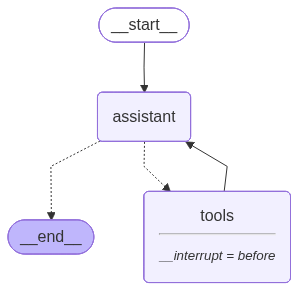

In [3]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [4]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 12 and 13")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 12 and 13
================================== Ai Message ==================================
Tool Calls:
  multiply (2khr5k0ak)
 Call ID: 2khr5k0ak
  Args:
    a: 12
    b: 13


We can get the state and look at the next node to call.

This is a nice way to see that the graph has been interrupted.

In [5]:
state = graph.get_state(thread)
state.next

('tools',)

Now, we'll introduce a nice trick.

When we invoke the graph with `None`, it will just continue from the last state checkpoint!

![breakpoints.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbae7985b747dfed67775d_breakpoints1.png)

For clarity, LangGraph will re-emit the current state, which contains the `AIMessage` with tool call.

And then it will proceed to execute the following steps in the graph, which start with the tool node.

We see that the tool node is run with this tool call, and it's passed back to the chat model for our final answer.

In [6]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (2khr5k0ak)
 Call ID: 2khr5k0ak
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: multiply

156
================================== Ai Message ==================================

The result of multiplying 12 and 13 is 156.


Now, lets bring these together with a specific user approval step that accepts user input.

In [8]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 39")}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Multiply 2 and 39
================================== Ai Message ==================================
Tool Calls:
  multiply (grdqrc1qg)
 Call ID: grdqrc1qg
  Args:
    a: 2
    b: 39


Do you want to call the tool? (yes/no):  yes


================================== Ai Message ==================================
Tool Calls:
  multiply (grdqrc1qg)
 Call ID: grdqrc1qg
  Args:
    a: 2
    b: 39
================================= Tool Message =================================
Name: multiply

78
================================== Ai Message ==================================

The result of multiplying 2 and 39 is 78.


### Breakpoints with LangGraph API

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

The LangGraph API [supports breakpoints](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_breakpoint/#sdk-initialization). 

In [1]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [2]:
# This is the URL of the local development server
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

As shown above, we can add `interrupt_before=["node"]` when compiling the graph that is running in Studio.

However, with the API, you can also pass `interrupt_before` to the stream method directly. 

In [10]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '2a3b1e7a-f6d9-44c2-a4b4-b7f67aa3691c', 'example': False}
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_ElnkVOf1H80dlwZLqO0PQTwS', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 18, 'prompt_tokens': 134, 'total_tokens': 152, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 't

Now, we can proceed from the breakpoint just like we did before by passing the `thread_id` and `None` as the input!

In [11]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=None,
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_ElnkVOf1H80dlwZLqO0PQTwS', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 18, 'prompt_tokens': 134, 'total_tokens': 152, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run-89ee14dc-5f46-4dd9-91d9-e922c4a23572-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_ElnkVOf1H80dlwZLqO0PQTwS', 'type': 'tool_call'}], 'invalid_tool_

In [19]:
from langchain_groq import ChatGroq

def add(a: float, b: float) -> float:
    """Add two numbers."""
    return a + b

def subtract(a: float, b: float) -> float:
    """Subtract b from a."""
    return a - b

def multiply(a: float, b: float) -> float:
    """Multiply two numbers."""
    return a * b

def divide(a: float, b: float) -> float:
    """Divide a by b."""
    if b == 0:
        return float('nan')  # avoid division by zero
    return a / b

def power(a: float, b: float) -> float:
    """Raise a to the power of b."""
    return a ** b


tools = [add, subtract, multiply, divide, power]

llm = ChatGroq(model="llama-3.3-70b-versatile")

llm_with_tools = llm.bind_tools(tools)


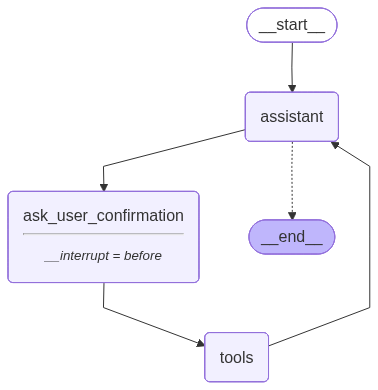

In [22]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START
from langgraph.prebuilt import ToolNode
from langchain_core.messages import SystemMessage

sys_msg = SystemMessage(
    content="You are a helpful assistant that can perform arithmetic. "
            "Identify each operation and propose it before executing."
)

def assistant(state: MessagesState):
    # Ask LLM to parse user prompt into operations
    response = llm_with_tools.invoke([sys_msg] + state["messages"])
    state["proposed_operations"] = response.content.splitlines()  # assuming LLM returns one operation per line
    return {"messages": state["messages"] + [response]}

# Ask user for confirmation before each tool call

def ask_user_confirmation(state: MessagesState):
    operations = state.get("proposed_operations", [])
    if not operations:
        return {"messages": state["messages"]}
    
    confirmed_operations = []
    for op in operations:
        user_input = input(f"Do you want to execute '{op}'? (yes/no): ").strip().lower()
        if user_input == "yes":
            confirmed_operations.append(op)
    
    state["confirmed_operations"] = confirmed_operations
    return {"messages": state["messages"]}

# Tools node: execute confirmed operations

def execute_tools(state: MessagesState):
    confirmed_ops = state.get("confirmed_operations", [])
    results = []
    for op in confirmed_ops:
        # Run each operation via ToolNode
        temp_state = MessagesState(messages=state["messages"] + [op])
        tool_node = ToolNode(tools)
        result = tool_node.run(temp_state)
        results.extend(result["messages"])
    state["messages"].extend(results)
    return {"messages": state["messages"]}

# Build graph

builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("ask_user_confirmation", ask_user_confirmation)
builder.add_node("tools", execute_tools)

builder.add_edge(START, "assistant")
builder.add_edge("assistant", "ask_user_confirmation")
builder.add_edge("ask_user_confirmation", "tools")
builder.add_edge("tools", "assistant")  # loop back to process next prompt

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=["ask_user_confirmation"], checkpointer=memory)

# Display graph
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [23]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 12 and 13 and divde the ressult by 9")}

# Thread
thread = {"configurable": {"thread_id": "11"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 12 and 13 and divde the ressult by 9
================================== Ai Message ==================================

To perform the given operation, we first need to multiply 12 and 13, then divide the result by 9. 

First, we will multiply 12 and 13.
Tool Calls:
  multiply (95pa9etvd)
 Call ID: 95pa9etvd
  Args:
    a: 12
    b: 13


In [24]:
state = graph.get_state(thread)
state.next

('ask_user_confirmation',)

In [25]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================

To perform the given operation, we first need to multiply 12 and 13, then divide the result by 9. 

First, we will multiply 12 and 13.
Tool Calls:
  multiply (95pa9etvd)
 Call ID: 95pa9etvd
  Args:
    a: 12
    b: 13
================================== Ai Message ==================================

To perform the given operation, we first need to multiply 12 and 13, then divide the result by 9. 

First, we will multiply 12 and 13.
Tool Calls:
  multiply (95pa9etvd)
 Call ID: 95pa9etvd
  Args:
    a: 12
    b: 13
================================== Ai Message ==================================

To perform the given operation, we first need to multiply 12 and 13, then divide the result by 9. 

First, we will multiply 12 and 13.
Tool Calls:
  multiply (95pa9etvd)
 Call ID: 95pa9etvd
  Args:
    a: 12
    b: 13
================================== Ai Message ==================================
Tool Calls:
  divid

In [26]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  divide (q6269bj4f)
 Call ID: q6269bj4f
  Args:
    a: 156
    b: 9
================================== Ai Message ==================================
Tool Calls:
  divide (q6269bj4f)
 Call ID: q6269bj4f
  Args:
    a: 156
    b: 9
================================== Ai Message ==================================
Tool Calls:
  divide (q6269bj4f)
 Call ID: q6269bj4f
  Args:
    a: 156
    b: 9
================================== Ai Message ==================================


In [27]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
================================== Ai Message ==================================
================================== Ai Message ==================================
================================== Ai Message ==================================

The result of multiplying 12 and 13 is 156. Then, dividing 156 by 9 equals 17.333333333333332.
